## Lab 2 Text Summarization for Webpage
Author: Sophia Herman
Date: June 2

#### Please install the necessary libraries:

pip install --user nltk beautifulsoup4 requests

In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import heapq
import re
from nltk.util import ngrams



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HCAG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HCAG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Text Summarization with Word Frequencies
#### Web Scraping with BeautifulSoup

Scrape text data from the specified Wikipedia page.

In [2]:

# Web scraping and preprocessing
url = 'https://en.wikipedia.org/wiki/Natural_language_processing'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
paragraphs = soup.find_all('p')
text = ' '.join([para.get_text() for para in paragraphs])
print(text[:1000])  # Print the first 1000 characters of the text for verification


Natural language processing (NLP) is an interdisciplinary subfield of computer science and information retrieval. It is primarily concerned with giving computers the ability to support and manipulate human language. It involves processing natural language datasets, such as text corpora or speech corpora, using either rule-based or probabilistic (i.e. statistical and, most recently, neural network-based) machine learning approaches. The goal is a computer capable of "understanding"[citation needed] the contents of documents, including the contextual nuances of the language within them. To this end, natural language processing often borrows ideas from theoretical linguistics. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.
 Challenges in natural language processing frequently involve speech recognition, natural-language understanding, and natural-language generation.
 Natural langu

#### Preprocess the Text Data

Tokenize words, remove stop words, and punctuation.

In [3]:
def preprocess_text(text):
    # Remove citations and numbers
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'\d+', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    # Tokenize words
    words = word_tokenize(text)
    # Convert to lowercase
    words = [word.lower() for word in words]
    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Preprocess the text
words = preprocess_text(text)
print(words[:50])  # Print the first 50 preprocessed words for verification


['natural', 'language', 'processing', 'nlp', 'interdisciplinary', 'subfield', 'computer', 'science', 'information', 'retrieval', 'primarily', 'concerned', 'giving', 'computers', 'ability', 'support', 'manipulate', 'human', 'language', 'involves', 'processing', 'natural', 'language', 'datasets', 'text', 'corpora', 'speech', 'corpora', 'using', 'either', 'probabilistic', 'statistical', 'recently', 'neural', 'machine', 'learning', 'approaches', 'goal', 'computer', 'capable', 'understanding', 'citation', 'needed', 'contents', 'documents', 'including', 'contextual', 'nuances', 'language', 'within']


#### Calculate Word Frequencies

In [4]:
# Calculate raw word frequencies
freq_dist = FreqDist(words)

# Calculate weighted word frequencies
max_freq = max(freq_dist.values())
weighted_freq_dist = {word: freq/max_freq for word, freq in freq_dist.items()}

print(list(freq_dist.items())[:10])  # Print the first 10 raw word frequencies for verification
print(list(weighted_freq_dist.items())[:10])  # Print the first 10 weighted word frequencies for verification


[('natural', 15), ('language', 23), ('processing', 13), ('nlp', 15), ('interdisciplinary', 3), ('subfield', 1), ('computer', 3), ('science', 3), ('information', 2), ('retrieval', 1)]
[('natural', 0.6521739130434783), ('language', 1.0), ('processing', 0.5652173913043478), ('nlp', 0.6521739130434783), ('interdisciplinary', 0.13043478260869565), ('subfield', 0.043478260869565216), ('computer', 0.13043478260869565), ('science', 0.13043478260869565), ('information', 0.08695652173913043), ('retrieval', 0.043478260869565216)]


#### Score the Sentences

Scores sentences based on the frequency of words they contain.
Each word's frequency is summed to get the sentence score.

In [5]:
# Score sentences based on word frequencies
def score_sentences(sentences, freq_dist):
    sentence_scores = {}
    for sentence in sentences:
        for word in word_tokenize(sentence.lower()):
            if word in freq_dist:
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = freq_dist[word]
                else:
                    sentence_scores[sentence] += freq_dist[word]
    return sentence_scores

# Tokenize sentences
sentences = sent_tokenize(re.sub(r'\[\d+\]', '', text))

# Score sentences using raw frequencies
sentence_scores_raw = score_sentences(sentences, freq_dist)

# Score sentences using weighted frequencies
sentence_scores_weighted = score_sentences(sentences, weighted_freq_dist)

print(list(sentence_scores_raw.items())[:5])  # Print the first 5 sentence scores (raw) for verification
print(list(sentence_scores_weighted.items())[:5])  # Print the first 5 sentence scores (weighted) for verification

[('Natural language processing (NLP) is an interdisciplinary subfield of computer science and information retrieval.', 79), ('It is primarily concerned with giving computers the ability to support and manipulate human language.', 31), ('It involves processing natural language datasets, such as text corpora or speech corpora, using either rule-based or probabilistic (i.e.', 67), ('statistical and, most recently, neural network-based) machine learning approaches.', 34), ('The goal is a computer capable of "understanding"[citation needed] the contents of documents, including the contextual nuances of the language within them.', 43)]
[('Natural language processing (NLP) is an interdisciplinary subfield of computer science and information retrieval.', 3.434782608695653), ('It is primarily concerned with giving computers the ability to support and manipulate human language.', 1.3478260869565217), ('It involves processing natural language datasets, such as text corpora or speech corpora, usin

#### Build a Summary

In [6]:
# Build a summary based on sentence count
def build_summary_by_sentence_count(sentence_scores, sentence_count):
    sorted_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    summary_sentences = [sentence for sentence, score in sorted_sentences[:sentence_count]]
    return ' '.join(summary_sentences)

# Build a summary based on word count
def build_summary_by_word_count(sentence_scores, word_count):
    sorted_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    summary_sentences = []
    current_word_count = 0
    for sentence, score in sorted_sentences:
        sentence_word_count = len(word_tokenize(sentence))
        if current_word_count + sentence_word_count <= word_count or not summary_sentences:
            summary_sentences.append(sentence)
            current_word_count += sentence_word_count
            if current_word_count >= word_count:
                break
    return ' '.join(summary_sentences)

# Build a summary based on percentage of the total word count
def build_summary_by_percentage(sentence_scores, percentage):
    total_words = sum([len(word_tokenize(sentence)) for sentence in sentence_scores])
    word_count = int(total_words * (percentage / 100))
    return build_summary_by_word_count(sentence_scores, word_count)


# Remove redundancy in the summary
def remove_redundancy(summary):
    sentences = sent_tokenize(summary)
    unique_sentences = []
    for sentence in sentences:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)


# Generate summaries using raw frequencies
summary_sentence_count_raw = build_summary_by_sentence_count(sentence_scores_raw, 3)
summary_sentence_count_raw = remove_redundancy(summary_sentence_count_raw)

summary_word_count_raw = build_summary_by_word_count(sentence_scores_raw, 50)
summary_word_count_raw = remove_redundancy(summary_word_count_raw)

summary_percentage_raw = build_summary_by_percentage(sentence_scores_raw, 20)
summary_percentage_raw = remove_redundancy(summary_percentage_raw)

# Generate summaries using weighted frequencies
summary_sentence_count_weighted = build_summary_by_sentence_count(sentence_scores_weighted, 3)
summary_sentence_count_weighted = remove_redundancy(summary_sentence_count_weighted)

summary_word_count_weighted = build_summary_by_word_count(sentence_scores_weighted, 50)
summary_word_count_weighted = remove_redundancy(summary_word_count_weighted)

summary_percentage_weighted = build_summary_by_percentage(sentence_scores_weighted, 20)
summary_percentage_weighted = remove_redundancy(summary_percentage_weighted)

summaries = {
    "Summary with Word Frequencies (Sentence Count)": summary_sentence_count_raw,
    "Summary with Word Frequencies (Word Count)": summary_word_count_raw,
    "Summary with Word Frequencies (Percentage)": summary_percentage_raw,
    "Summary with Weighted Frequencies (Sentence Count)": summary_sentence_count_weighted,
    "Summary with Weighted Frequencies (Word Count)": summary_word_count_weighted,
    "Summary with Weighted Frequencies (Percentage)": summary_percentage_weighted,
}

for key, value in summaries.items():
    print(f"{key}:\n{value}\n")


Summary with Word Frequencies (Sentence Count):
As an example, George Lakoff offers a methodology to build natural language processing (NLP) algorithms through the perspective of cognitive science, along with the findings of cognitive linguistics, with two defining aspects:
 Ties with cognitive linguistics are part of the historical heritage of NLP, but they have been less frequently addressed since the statistical turn during the 1990s. Likewise, ideas of cognitive NLP are inherent to neural models multimodal NLP (although rarely made explicit) and developments in artificial intelligence, specifically tools and technologies using large language model approaches and new directions in artificial general intelligence based on the free energy principle by British neuroscientist and theoretician at University College London Karl J. Friston. The premise of symbolic NLP is well-summarized by John Searle's Chinese room experiment: Given a collection of rules (e.g., a Chinese phrasebook, with 

## Step 2: Text Summarization with N-grams
#### Generate N-grams and Calculate Frequencies

[(('natural', 'language'), 15), (('language', 'processing'), 12), (('processing', 'nlp'), 2), (('nlp', 'is'), 2), (('is', 'an'), 2), (('an', 'interdisciplinary'), 2), (('interdisciplinary', 'subfield'), 1), (('subfield', 'of'), 1), (('of', 'computer'), 1), (('computer', 'science'), 1)]
[(('natural', 'language', 'processing'), 10), (('language', 'processing', 'nlp'), 2), (('processing', 'nlp', 'is'), 1), (('nlp', 'is', 'an'), 1), (('is', 'an', 'interdisciplinary'), 2), (('an', 'interdisciplinary', 'subfield'), 1), (('interdisciplinary', 'subfield', 'of'), 1), (('subfield', 'of', 'computer'), 1), (('of', 'computer', 'science'), 1), (('computer', 'science', 'and'), 1)]


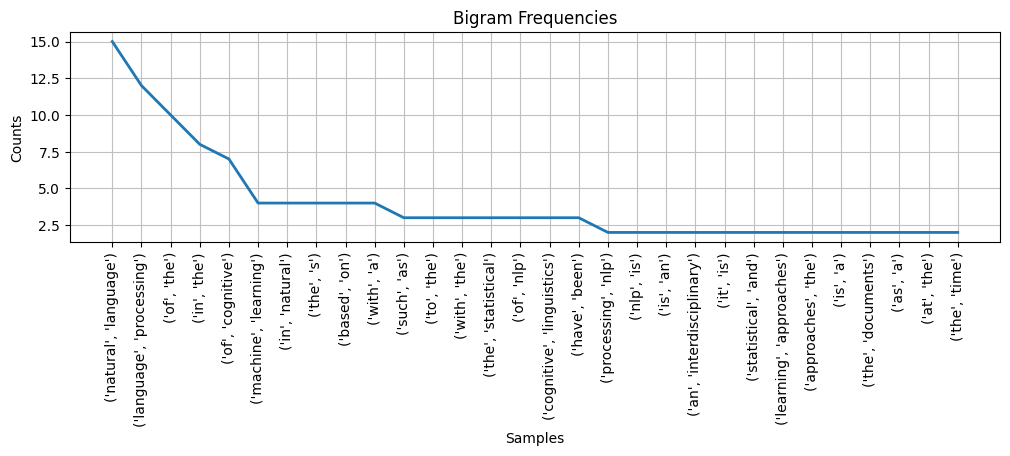

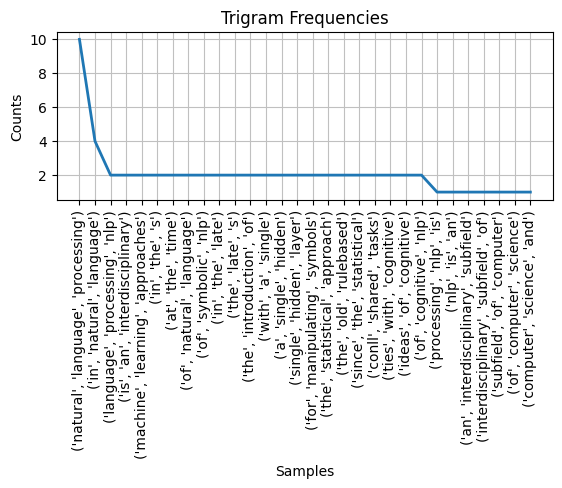

<Figure size 640x480 with 0 Axes>

In [7]:

# Preprocess text to remove punctuation and symbols
def preprocess_text_for_ngrams(text):
    # Remove citations and numbers
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

# Generate n-grams from the text
def get_ngrams(text, n):
    words = word_tokenize(text.lower())
    n_grams = ngrams(words, n)
    return FreqDist(n_grams)

# Preprocess text
preprocessed_text = preprocess_text_for_ngrams(text)

# Generate bigrams and trigrams
bigrams = get_ngrams(preprocessed_text, 2)
trigrams = get_ngrams(preprocessed_text, 3)

# Print the first 10 bigrams and trigrams for verification
print(list(bigrams.items())[:10])
print(list(trigrams.items())[:10])

# Plotting the frequencies for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Bigram Frequencies')
bigrams.plot(30, cumulative=False)
plt.subplot(2, 1, 2)
plt.title('Trigram Frequencies')
trigrams.plot(30, cumulative=False)
plt.tight_layout()
plt.show()

#### Calculate Sentence Scores with N-grams

In [8]:
# Calculate weighted frequencies for bigrams and trigrams
def find_weighted_frequency(freq_dist):
    max_freq = max(freq_dist.values())
    weighted_freq = {ngram: freq / max_freq for ngram, freq in freq_dist.items()}
    return weighted_freq

# Find weighted frequencies for bigrams and trigrams
weighted_freq_dist_bigrams = find_weighted_frequency(bigrams)
weighted_freq_dist_trigrams = find_weighted_frequency(trigrams)

# Print weighted frequencies for verification
print(list(weighted_freq_dist_bigrams.items())[:20])  # Print the first 20 weighted bigram frequencies for verification
print(list(weighted_freq_dist_trigrams.items())[:20])  # Print the first 20 weighted trigram frequencies for verification


# Function to score sentences based on n-gram frequencies
def calculate_sentence_scores_ngram(sentences, ngram_freqs, n):
    sentence_scores_ngram = {}
    for sentence in sentences:
        for ngram in ngrams(word_tokenize(sentence.lower()), n):
            if ngram in ngram_freqs:
                if sentence not in sentence_scores_ngram:
                    sentence_scores_ngram[sentence] = ngram_freqs[ngram]
                else:
                    sentence_scores_ngram[sentence] += ngram_freqs[ngram]
    return sentence_scores_ngram

# Score sentences using bigrams and trigrams
sentence_scores_bigrams = calculate_sentence_scores_ngram(sentences, weighted_freq_dist_bigrams, 2)
sentence_scores_trigrams = calculate_sentence_scores_ngram(sentences, weighted_freq_dist_trigrams, 3)

print(list(sentence_scores_bigrams.items())[:5])  # Print the first 5 bigram sentence scores for verification
print(list(sentence_scores_trigrams.items())[:5])  # Print the first 5 trigram sentence scores for verification





[(('natural', 'language'), 1.0), (('language', 'processing'), 0.8), (('processing', 'nlp'), 0.13333333333333333), (('nlp', 'is'), 0.13333333333333333), (('is', 'an'), 0.13333333333333333), (('an', 'interdisciplinary'), 0.13333333333333333), (('interdisciplinary', 'subfield'), 0.06666666666666667), (('subfield', 'of'), 0.06666666666666667), (('of', 'computer'), 0.06666666666666667), (('computer', 'science'), 0.06666666666666667), (('science', 'and'), 0.06666666666666667), (('and', 'information'), 0.06666666666666667), (('information', 'retrieval'), 0.06666666666666667), (('retrieval', 'it'), 0.06666666666666667), (('it', 'is'), 0.13333333333333333), (('is', 'primarily'), 0.06666666666666667), (('primarily', 'concerned'), 0.06666666666666667), (('concerned', 'with'), 0.06666666666666667), (('with', 'giving'), 0.06666666666666667), (('giving', 'computers'), 0.06666666666666667)]
[(('natural', 'language', 'processing'), 1.0), (('language', 'processing', 'nlp'), 0.2), (('processing', 'nlp',

#### Generate the Summary

In [9]:
# Function to build a summary based on sentence count
def build_summary_by_sentence_count(sentence_scores, n):
    summary_sentences = heapq.nlargest(n, sentence_scores, key=sentence_scores.get)
    return ' '.join(summary_sentences)

# Function to build a summary based on word count
def build_summary_by_word_count(sentence_scores, word_count):
    sorted_sentences = sorted(sentence_scores.keys(), key=lambda x: sentence_scores[x], reverse=True)
    current_word_count = 0
    summary_sentences = []
    for sentence in sorted_sentences:
        sentence_word_count = len(word_tokenize(sentence))
        if current_word_count + sentence_word_count <= word_count or not summary_sentences:
            summary_sentences.append(sentence)
            current_word_count += sentence_word_count
            if current_word_count > word_count:
                break
    return ' '.join(summary_sentences)

# Function to build a summary based on percentage of the total word count
def build_summary_by_percentage(sentence_scores, percentage):
    total_words = sum([len(word_tokenize(sentence)) for sentence in sentence_scores])
    word_count = int(total_words * (percentage / 100))
    return build_summary_by_word_count(sentence_scores, word_count)

# Function to remove redundancy in the summary
def remove_redundancy(summary):
    sentences = sent_tokenize(summary)
    unique_sentences = []
    for sentence in sentences:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)


# Generate summaries using bigrams
summary_sentence_count_bigrams = build_summary_by_sentence_count(sentence_scores_bigrams, 3)
summary_sentence_count_bigrams = remove_redundancy(summary_sentence_count_bigrams)

summary_word_count_bigrams = build_summary_by_word_count(sentence_scores_bigrams, 50)
summary_word_count_bigrams = remove_redundancy(summary_word_count_bigrams)

summary_percentage_bigrams = build_summary_by_percentage(sentence_scores_bigrams, 20)
summary_percentage_bigrams = remove_redundancy(summary_percentage_bigrams)

# Generate summaries using trigrams
summary_sentence_count_trigrams = build_summary_by_sentence_count(sentence_scores_trigrams, 3)
summary_sentence_count_trigrams = remove_redundancy(summary_sentence_count_trigrams)

summary_word_count_trigrams = build_summary_by_word_count(sentence_scores_trigrams, 50)
summary_word_count_trigrams = remove_redundancy(summary_word_count_trigrams)

summary_percentage_trigrams = build_summary_by_percentage(sentence_scores_trigrams, 20)
summary_percentage_trigrams = remove_redundancy(summary_percentage_trigrams)

print("Summary with Bigrams (Sentence Count):")
print(summary_sentence_count_bigrams)
print("\nSummary with Bigrams (Word Count):")
print(summary_word_count_bigrams)
print("\nSummary with Bigrams (Percentage):")
print(summary_percentage_bigrams)

print("\nSummary with Trigrams (Sentence Count):")
print(summary_sentence_count_trigrams)
print("\nSummary with Trigrams (Word Count):")
print(summary_word_count_trigrams)
print("\nSummary with Trigrams (Percentage):")
print(summary_percentage_trigrams)


Summary with Bigrams (Sentence Count):
As an example, George Lakoff offers a methodology to build natural language processing (NLP) algorithms through the perspective of cognitive science, along with the findings of cognitive linguistics, with two defining aspects:
 Ties with cognitive linguistics are part of the historical heritage of NLP, but they have been less frequently addressed since the statistical turn during the 1990s. Starting in the late 1980s, however, there was a revolution in natural language processing with the introduction of machine learning algorithms for language processing. Nevertheless, approaches to develop cognitive models towards technically operationalizable frameworks have been pursued in the context of various frameworks, e.g., of cognitive grammar, functional grammar, construction grammar, computational psycholinguistics and cognitive neuroscience (e.g., ACT-R), however, with limited uptake in mainstream NLP (as measured by presence on major conferences of 

## Step 3: Compare the two methods for text summarization.

#### The word frequency method
The word frequency method relies on the frequency of individual words to score and rank sentences. This approach is straightforward and computationally efficient. By identifying the most frequently occurring words, it assigns higher scores to sentences containing these words, thus highlighting key sentences in the text. However, this method has limitations. It often favors sentences with commonly occurring words, which may not always capture the full context of the text. Consequently, summaries generated using word frequencies might lack coherence and fail to reflect the nuanced meaning of the original content.

#### The N-grams method
The N-grams method considers sequences of words, known as N-grams, to capture more context and provide potentially more coherent summaries. By analyzing bigrams (two-word sequences) and trigrams (three-word sequences), this method takes into account the relationship between words and their immediate context. This can result in more accurate summaries that better represent the original text. However, the N-grams method is more complex and computationally intensive, especially with larger values of N. It also requires more sophisticated preprocessing to handle punctuation and symbols effectively.

#### Final Comparison
Summaries generated using word frequencies and N-grams reveal distinct differences. For example, the word frequency method tends to highlight key individual words, resulting in summaries that may repeat certain high-frequency terms without sufficient context. In contrast, the N-grams method produces summaries that are more coherent and contextually rich, as it captures phrases and word sequences that convey more meaningful information. For instance, summaries based on bigrams and trigrams often include more detailed descriptions and technical terms, providing a clearer understanding of complex concepts. The word frequency method, while simpler, may overlook important relationships between words, leading to less informative summaries.

Both methods have their strengths and weaknesses. The word frequency method is simpler and faster, making it suitable for large texts where quick summarization is needed. The N-grams method, while more resource-intensive, offers more accurate and coherent summaries, especially for texts where context and word sequences are crucial. The choice between these methods depends on the specific requirements of the summarization task, such as the need for speed versus the need for accuracy and contextual understanding.